### Lab 2: Signal vs. Noise Example with ROC curve

Consider Example 49 from the lecture, where 

\begin{align*}
 p(x|Y=0) &= \mathcal{N}(0, \sigma^2) \\
 p(x|Y=1) &= \mathcal{N}(s, \sigma^2)
\end{align*}

![Singal vs. Noise](signal_and_noise.png)

### Task 1
Given threshold $\eta$, compute TPR and FPR for the Likelihood Ratio Test (LRT).

In [10]:
import math
# you can use math.erfc(x) for erfc(x) function

def FPR(s, sigma, gamma):
    return 1/2 * math.erfc((gamma)/(math.sqrt(2) * sigma))

def TPR(s, sigma, gamma):
    return 1/2 * math.erfc((gamma - s)/(math.sqrt(2) * sigma))

# Test
s = 2
sigma = 1

assert abs(TPR(s, sigma, 3) - 0.15865525393145707) < 1e-5
assert TPR(s, sigma, s) == 0.5
assert abs(FPR(s, sigma, 1) - 0.15865525393145707) < 1e-5
assert FPR(s, sigma, 0) == 0.5

### Task 2
Using above to plot the ROC curve.

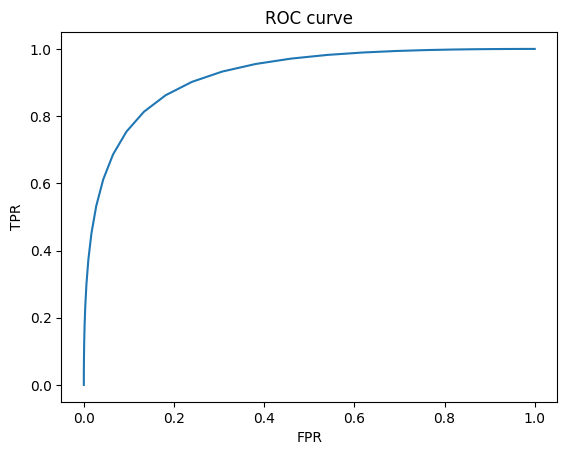

In [11]:
import numpy as np
import matplotlib.pyplot as plt

s = 2
sigma = 1

# plot ROC curve
gamma_s = np.linspace(-10, 10, 100)

def get_roc(gamma_s, s, sigma):
    tpr = [TPR(s, sigma, gamma) for gamma in gamma_s]
    fpr = [FPR(s, sigma, gamma) for gamma in gamma_s]
    return tpr, fpr

tpr, fpr = get_roc(gamma_s, s, sigma)
plt.plot(fpr, tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve')
plt.show()



### Task 3

Plot your ROC curve for several values of Signal to Noise Ratio (SNR) 

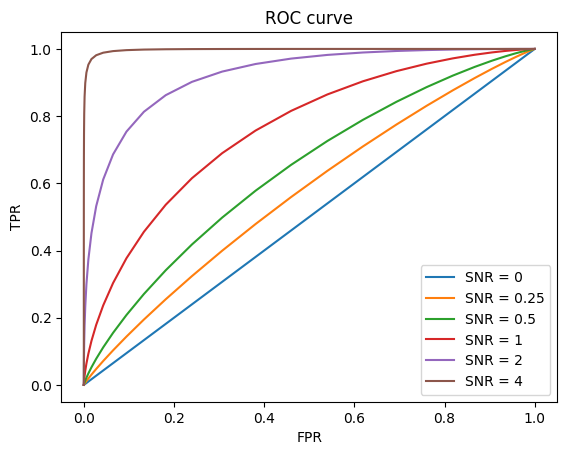

In [12]:
SNR_s = [0, 0.25, 0.5, 1, 2, 4]

for SNR in SNR_s:
    s = SNR
    sigma = 1
    tpr, fpr = get_roc(gamma_s, s, sigma)
    plt.plot(fpr, tpr, label='SNR = {}'.format(SNR))

plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve')
plt.legend()
plt.show()

## ROC Curves in Practice

In practice, we do not have access to full population but only finite samples. For each sample, we evaluate our score function $f$, e.g. likelihood ratio. To plot ROC curve, we vary threshold $\eta$ for the score function to make plot ROC curve. To estimate TPR and FPR, we compare the predicted label with the true label. 

### Task 4
Given sample of 1000 data points from both classes, i.e., distributions $x|Y=1$ and $x|Y=0$, construct the ROC. Due to numerical stability, use log-likelihood ratio to predict the score (recall lab 1).



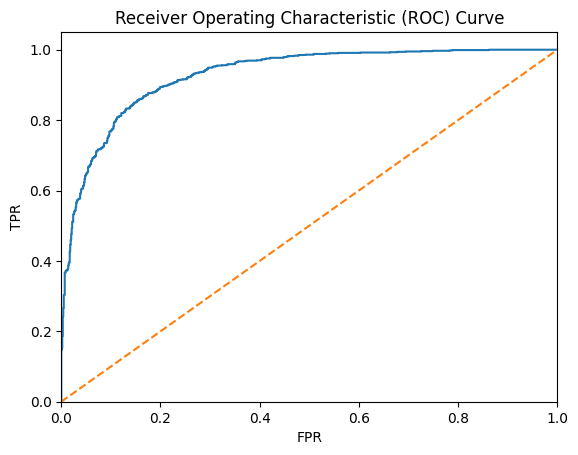

In [13]:
s = 2
sigma = 1

# Data generation
def generate_data(N, s, sigma):
    x_0 = sigma * np.random.randn(N)
    x_1 = s + sigma * np.random.randn(N)
    x = np.concatenate([x_0, x_1])
    y = np.concatenate([np.zeros(N), np.ones(N)])
    return x, y

N = 1000
x, y_true = generate_data(N, s, sigma)

# log-likelihood ratio
def log_pdf_normal(x, mu, sigma):
    const_norm = 1 / (math.sqrt(2 * math.pi) * sigma)
    exponent = -(x - mu) ** 2 / (2 * sigma ** 2)
    return np.log(const_norm) + exponent

def log_likelihood_ratio(x, s, sigma):
    return log_pdf_normal(x, s, sigma) - log_pdf_normal(x, 0, sigma)

# ROC curve
y_score = np.array([log_likelihood_ratio(x_i, s, sigma) for x_i in x])

# We will sort the scores so we can do precitions easily
y_score_sorted = np.sort(y_score)
# We will adjust true labels according to the order of scores
y_true_sorted = y_true[np.argsort(y_score)]

# plot ROC curve
# With sorted scores, we can compute TPR and FPR for different thresholds
def get_roc_est(y_true_sorted, y_score_sorted):
    tpr = []
    fpr = []
    for i in range(len(y_true)):
        # For given i, we predict all scores above i as positive
        # TPR is the ratio of positive samples that are correctly classified
        tpr.append(np.sum(y_true_sorted[i:]) / np.sum(y_true_sorted))
        # FPR is the ratio of negative samples that are incorrectly classified
        fpr.append(np.sum(1 - y_true_sorted[i:]) / np.sum(1 - y_true_sorted))
    return tpr, fpr

tpr_est, fpr_est = get_roc_est(y_true_sorted, y_score_sorted)

plt.plot(fpr_est, tpr_est)
plt.plot([0, 1], [0, 1], linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.show()



### Task 5
Compare this with the exact curve that you plotted before.

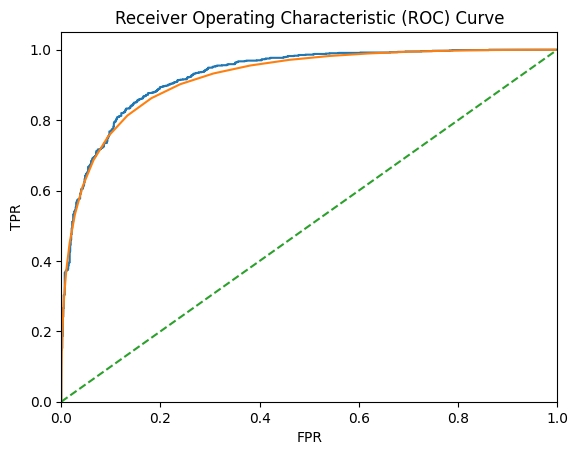

In [14]:
tpr_true, fpr_true = get_roc(gamma_s, s, sigma)

plt.plot(fpr_est, tpr_est, label='Estimated')
plt.plot(fpr_true, tpr_true, label='True')
plt.plot([0, 1], [0, 1], linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.show()

### Task 6
Look up how to plot ROC curve using popular data science python package `scikit-learn` and verify that the curves overlap. 

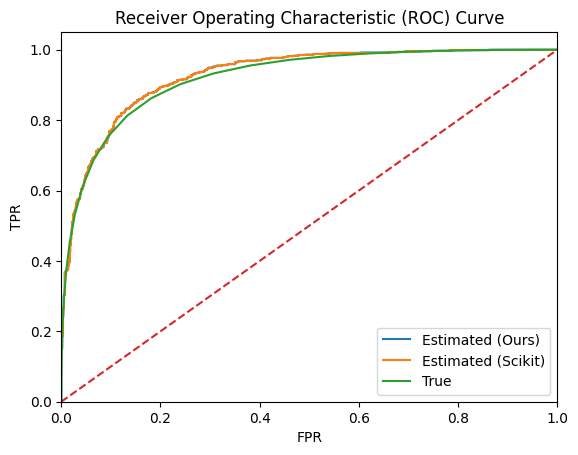

In [15]:
from sklearn.metrics import roc_curve

fpr_scikit, tpr_scikit, thresholds = roc_curve(y_true, y_score)

plt.plot(fpr_est, tpr_est, label='Estimated (Ours)')
plt.plot(fpr_scikit, tpr_scikit, label='Estimated (Scikit)')
plt.plot(fpr_true, tpr_true, label='True')
plt.plot([0, 1], [0, 1], linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

### Task 6 
Propose some non-trivial predictor function $f$ (different from likelihood ratio) and plot its ROC curve (using finite samples). Does it lie below the optimal ROC?  


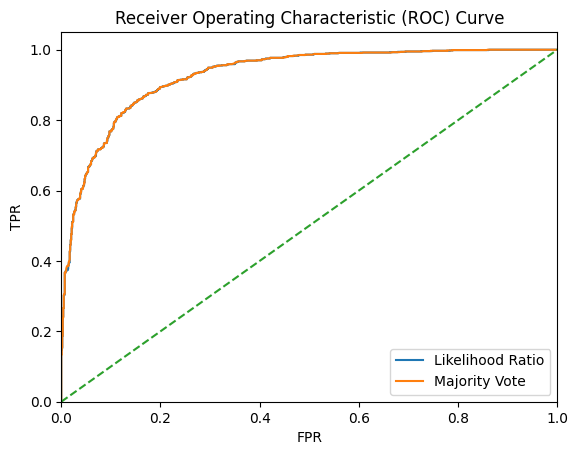

In [16]:
# We can use majority vote from the samples that lie within sigma away from x

def majority_vote(x_i, y_true, sigma):
    # We will use the fact that True is 1 and False is 0
    # We will average all the labels within sigma away from x_i
    return np.mean(y_true[np.abs(x - x_i) < sigma])

y_score_mv = np.array([majority_vote(x_i, y_true, sigma) for x_i in x])

fpr_mv, tpr_mv, thresholds_mv = roc_curve(y_true, y_score_mv)

plt.plot(fpr_est, tpr_est, label='Likelihood Ratio')
plt.plot(fpr_mv, tpr_mv, label='Majority Vote')
plt.plot([0, 1], [0, 1], linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()